# Demography table + Enrgy table (non-smart meter)

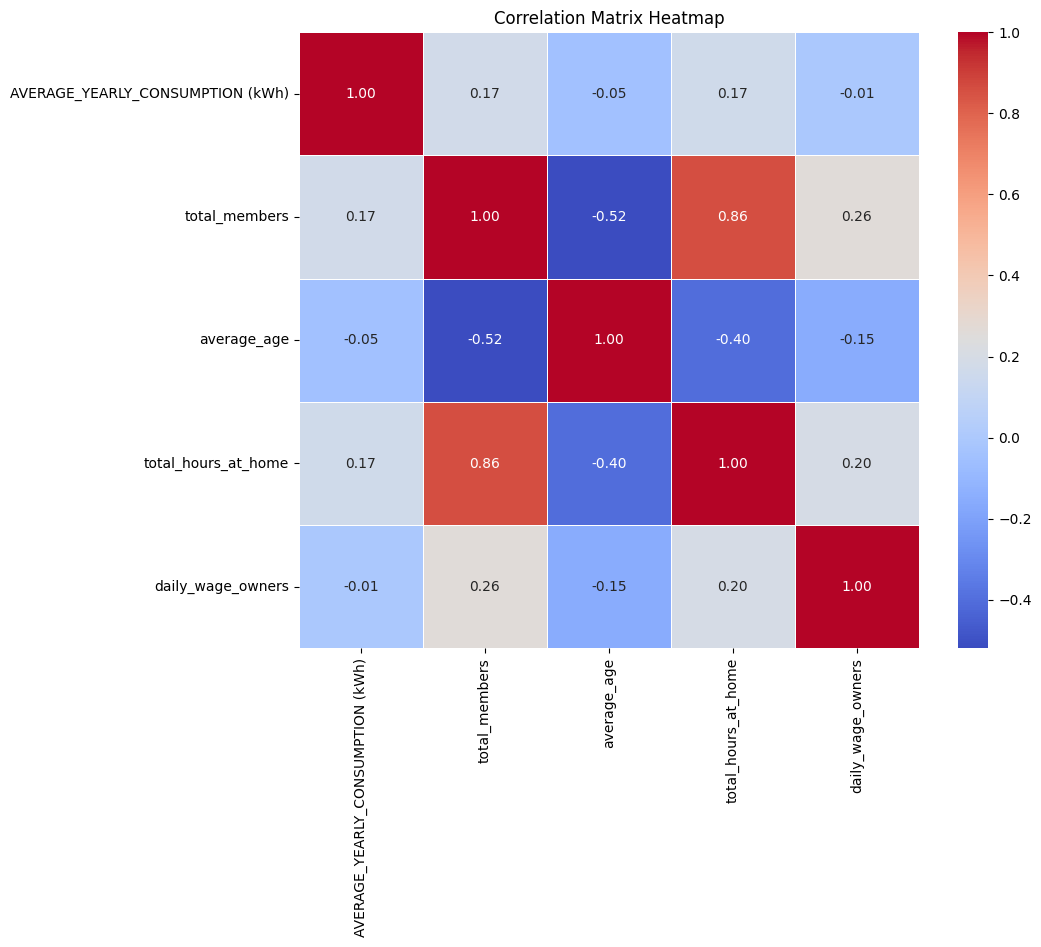

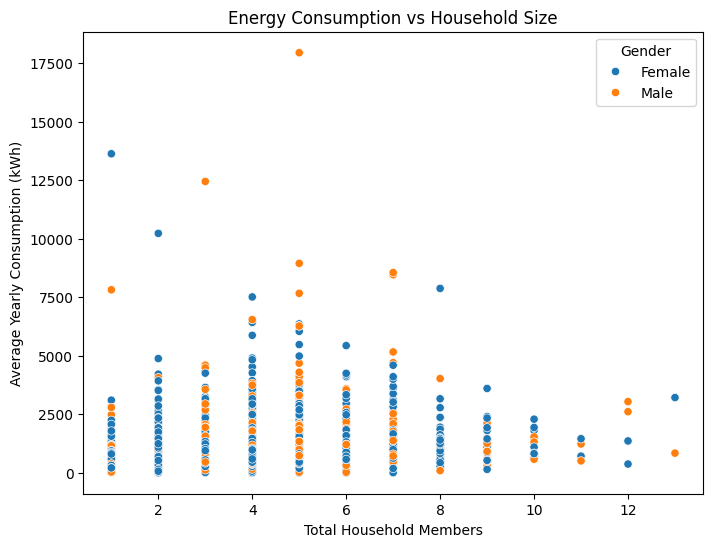

C:\Users\Kalindu Denuwan\AppData\Local\Temp\ipykernel_16260\3772722535.py:211: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='common_education_level', y='AVERAGE_YEARLY_CONSUMPTION (kWh)', palette='Set2')


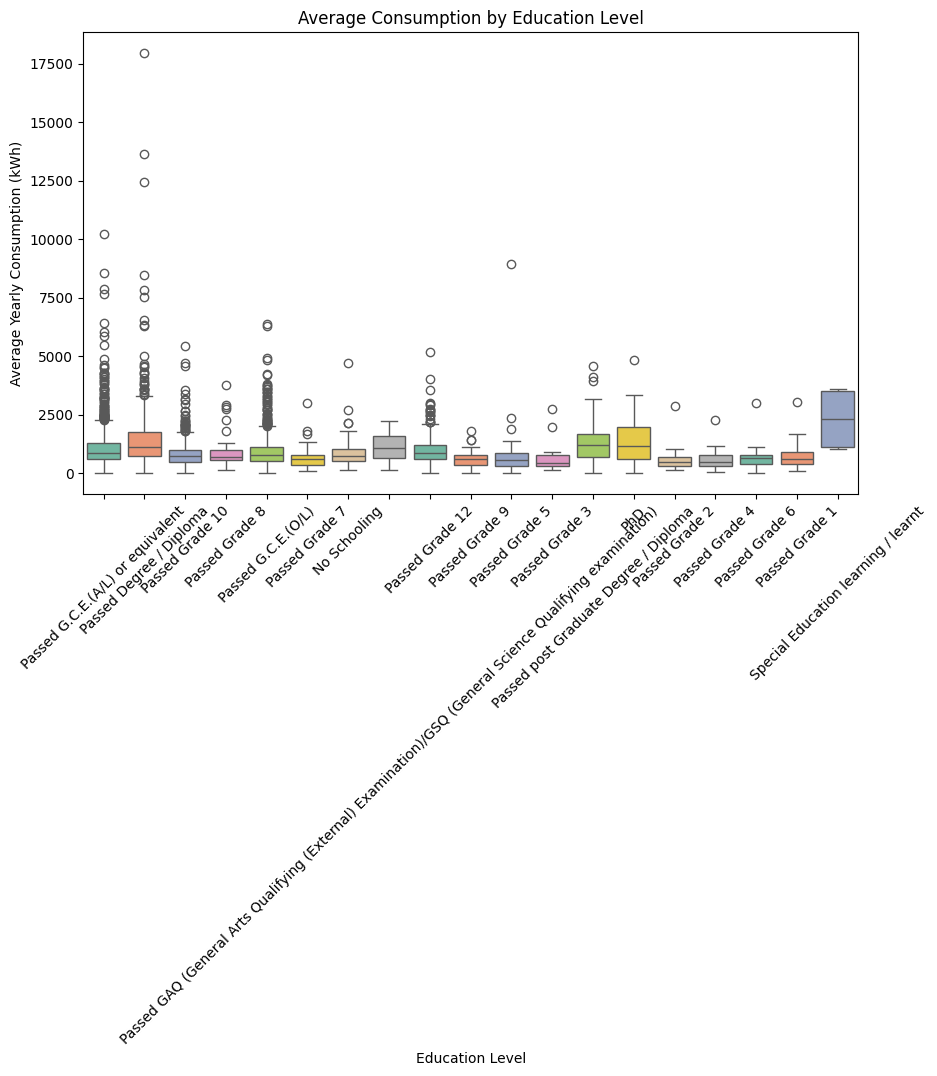

In [70]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
energy_data = pd.read_csv('non_smart_meter_data.csv')  
demographics_data = pd.read_csv('w1_demographics.csv') 

# -------------------------
# Step 1: Encode Categorical Columns in Demographics Data
# -------------------------

# Encoding maps
encoding_maps = {
    'members_went_out_for_work': {
        'Yes, went daily during working days': 2,
        'Yes, went on most of the days': 1,
        'No, worked from home': 0
    },
    'common_relationship': {
        'Head of the household': 1,
        'Wife/Husband': 2,
        'Son/daughter': 3,
        'Son-in-law/Daughter in law': 4,
        'Parents of the head of Household/spouse': 5
    },
    'common_gender': {
        'male': 1,
        'female': 0
    },
    'common_ethnicity': {
        'Sinhala': 1,
        'Sri Lankan Tamil': 2,
        'Sri Lankan Moor/Muslim': 3
    },
    'common_religion': {
        'Buddhism': 1,
        'Islam': 2,
        'Hinduism': 3
    },
    'common_marital_status': {
        'Currently married (registered)': 1,
        'Widowed': 2,
        'Never married': 3,
        'Divorced': 4
    },
    'common_education_level': {
        'Passed G.C.E.(A/L) or equivalent': 3,
        'Passed post Graduate Degree / Diploma': 5,
        'Passed Degree / Diploma': 4,
        'Passed G.C.E.(O/L)': 2,
        'Passed Grade 10': 1,        
        'Passed Grade 9': 1,
        'Passed Grade 8': 1,
        'Passed Grade 7': 1,
        'Passed Grade 6': 1,
        'Passed Grade 5': 1,
        'Passed Grade 4': 1,
        'Passed Grade 3': 1,
        'Passed Grade 2': 1,
        'Passed Grade 1': 1,
        'No Schooling': 0
    },
    'common_main_activity': {
        'Household activities': 0,
        'Engaged in economic activity/ currently employed/ engaged in own business': 1,
        'Retired and obtaining government/semi-government pension payment and currently not engaged in economic activity (not employed elsewhere or not engaged in any own business)': 2,
        'Retired and obtaining government/semi-government pension payment and is currently engaged in economic activity (employed elsewhere other than the place where he/she is receiving the pension from / engaged in own business)': 3,
        'Too old / Disable/ unable to work': 4,
        'Student': 5,
        'Seeking for and available to work': 6
    },
    'common_employment_status': {
        'Government employee': 1,
        'Private sector employee': 2,
        'Employer': 3,
        'Own account worker': 4,
        'Contributing family worker': 5,
        'Semi government employee': 6
    }
}

def map_education_level(value):
    # Check if the value contains "Passed Grade" followed by a number
    if re.match(r'Passed Grade \d+', value):
        return 'Schooling below G.C.E.(O/L)'
    return value

updated_education_level = {
    map_education_level(key): 1 if map_education_level(key) == 'Schooling below G.C.E.(O/L)' else value
    for key, value in encoding_maps['common_education_level'].items()
}

# Apply encodings to the demographic data
for column, mapping in encoding_maps.items():
    if column in demographics_data.columns:
        demographics_data[column] = demographics_data[column].map(mapping)

# -------------------------
# Step 2: Aggregate Demographic Data by Household
# -------------------------

# Helper function for mode aggregation
def mode_agg(series):
    if not series.empty and not series.mode().empty:
        return series.mode()[0]
    return None

# Aggregating demographic data
agg_demographics = demographics_data.groupby('household_ID').agg({
    'member_ID': 'count',  # Total members in household
    'age': 'mean',  # Average age
    'no_of_hours_stayed_at_home_during_last_week': 'sum',  # Total hours at home
    'member_went_out_for_work_or_not_during_last_week': 'sum',  # Members going out for work
    'highest_level_of_education': mode_agg,  # Most common education level
    'relationship_to_the_head_of_household': mode_agg,  # Most common relationship
    'gender': mode_agg,  # Most common gender
    'ethnicity': mode_agg,  # Most common ethnicity
    'religion': mode_agg,  # Most common religion
    'marital_status': mode_agg,  # Most common marital status
    'main_activity_engaged_in': mode_agg,  # Most common main activity
    'daily_wage_owner_or_not': lambda x: (x == 'Yes').sum(),  # Count of daily wage owners
    'employment_status_of_the_main_occupation': mode_agg  # Most common employment status
}).reset_index()

agg_demographics.rename(columns={
    'member_ID': 'total_members',
    'age': 'average_age',
    'no_of_hours_stayed_at_home_during_last_week': 'total_hours_at_home',
    'member_went_out_for_work_or_not_during_last_week': 'members_went_out_for_work',
    'highest_level_of_education': 'common_education_level',
    'relationship_to_the_head_of_household': 'common_relationship',
    'gender': 'common_gender',
    'ethnicity': 'common_ethnicity',
    'religion': 'common_religion',
    'marital_status': 'common_marital_status',
    'main_activity_engaged_in': 'common_main_activity',
    'daily_wage_owner_or_not': 'daily_wage_owners',
    'employment_status_of_the_main_occupation': 'common_employment_status'
}, inplace=True)

# -------------------------
# Step 3: Aggregate Energy Data by Household
# -------------------------

# Convert the 'month' column to datetime if it's not already
energy_data['month'] = pd.to_datetime(energy_data['month'], errors='coerce')

# Ensure 'consumption' is numeric
energy_data['consumption'] = pd.to_numeric(energy_data['consumption'], errors='coerce')

# Drop rows where 'month' or 'consumption' are NaN
energy_data = energy_data.dropna(subset=['month', 'consumption'])

# Extract the year from the 'month' column
energy_data['year'] = energy_data['month'].dt.year

# Group by 'household_ID' and 'year', then calculate the sum of consumption per year
yearly_consumption = energy_data.groupby(['household_ID', 'year']).agg({
    'consumption': 'sum'  # Total consumption per year for each household
}).reset_index()

# Calculate the average yearly consumption for each household
agg_energy = yearly_consumption.groupby('household_ID').agg({
    'consumption': 'mean'  # Average yearly consumption
}).reset_index()

# Rename columns for clarity
agg_energy.rename(columns={'consumption': 'AVERAGE_YEARLY_CONSUMPTION (kWh)'}, inplace=True)

# -------------------------
# Step 4: Merge Energy and Demographic Data
# -------------------------

merged_data = pd.merge(agg_energy, agg_demographics, on='household_ID', how='inner')

# -------------------------
# Step 5: Correlation Analysis
# -------------------------

# Select numeric columns for correlation
correlation_data = merged_data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# -------------------------
# Visualization: Correlation Matrix Heatmap
# -------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# -------------------------
# Additional Visualization: Energy Consumption vs Household Size
# -------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_data, x='total_members', y='AVERAGE_YEARLY_CONSUMPTION (kWh)', hue='common_gender')
plt.title('Energy Consumption vs Household Size')
plt.xlabel('Total Household Members')
plt.ylabel('Average Yearly Consumption (kWh)')
plt.legend(title='Gender')
plt.show()

# -------------------------
# Additional Visualization: Average Consumption by Education Level
# -------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='common_education_level', y='AVERAGE_YEARLY_CONSUMPTION (kWh)', palette='Set2')
plt.title('Average Consumption by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Yearly Consumption (kWh)')
plt.xticks(rotation=45)
plt.show()


1. Apply k-means clustering to filter out in effcient house holds based on demographic details and energy consumption

Inefficient Households (Cluster: 2)
     household_ID  per_capita_consumption  total_members  cluster
974        ID0975             5115.500000              2        2
2659       ID2660             7818.666667              1        2
3884       ID3885            13634.666667              1        2


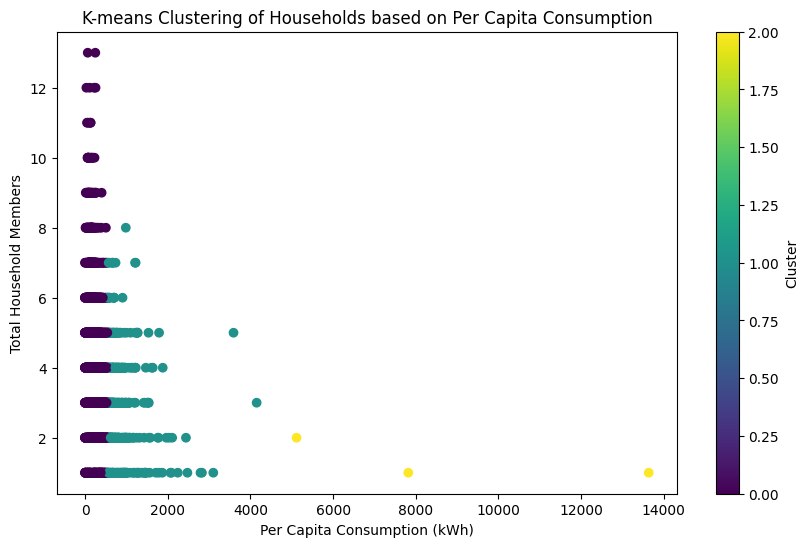

In [71]:
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Add per capita consumption column
merged_data['per_capita_consumption'] = merged_data['AVERAGE_YEARLY_CONSUMPTION (kWh)'] / merged_data['total_members']

# Step 2: Prepare data for clustering (you can select features that make sense for identifying inefficiency)
clustering_data = merged_data[['per_capita_consumption', 'total_members']]

# Step 3: Apply K-means clustering to segment households
# You may choose the number of clusters based on domain knowledge or use methods like the elbow method.
kmeans = KMeans(n_clusters=3, random_state=42)  # 3 clusters, adjust as necessary
merged_data['cluster'] = kmeans.fit_predict(clustering_data)

# Step 4: Identify inefficient households based on their cluster
# Assume that households in the cluster with the highest average per capita consumption are inefficient
# You can also analyze the cluster centers to decide which cluster corresponds to inefficiency.
cluster_centers = kmeans.cluster_centers_
inefficient_cluster = np.argmax(cluster_centers[:, 0])  # Index of the cluster with the highest per capita consumption

# Step 5: Filter out inefficient households (those in the inefficient cluster)
inefficient_households = merged_data[merged_data['cluster'] == inefficient_cluster]

# Print the inefficient households (or you can save them to a new CSV)
print("Inefficient Households (Cluster: {})".format(inefficient_cluster))
print(inefficient_households[['household_ID', 'per_capita_consumption', 'total_members', 'cluster']])

# If you want to exclude inefficient households:
filtered_data = merged_data[merged_data['cluster'] != inefficient_cluster]

# If you'd like to visualize the clustering results:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['per_capita_consumption'], merged_data['total_members'], c=merged_data['cluster'], cmap='viridis')
plt.title('K-means Clustering of Households based on Per Capita Consumption')
plt.xlabel('Per Capita Consumption (kWh)')
plt.ylabel('Total Household Members')
plt.colorbar(label='Cluster')
plt.show()


2. Apply Sri Lanakan avarage per capita electricity energy consumtion value 469.4 kwh as threshold to compare with k-means clustering resulsts

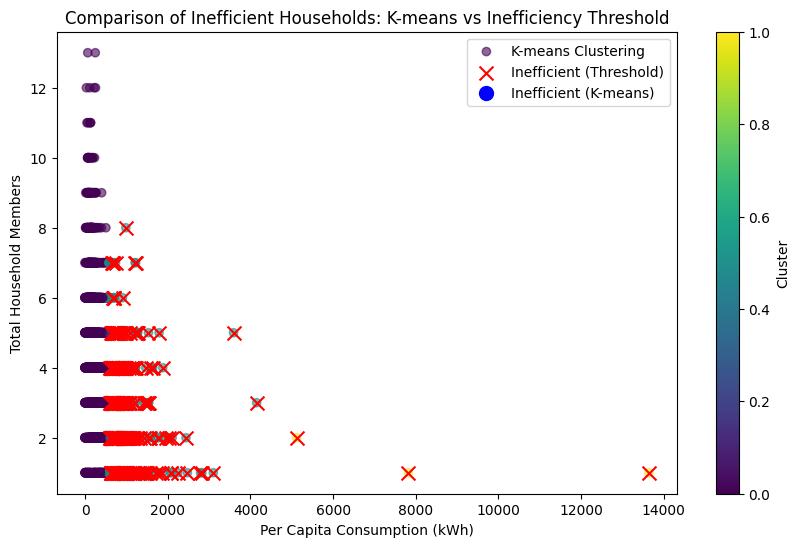


Inefficient Households (Threshold):
     household_ID  AVERAGE_YEARLY_CONSUMPTION (kWh)  per_capita_consumption
12         ID0013                       1275.666667             1275.666667
23         ID0024                       2006.000000             1003.000000
42         ID0043                       3156.666667             1052.222222
55         ID0056                       1004.000000             1004.000000
65         ID0066                       3757.666667              751.533333
...           ...                               ...                     ...
3947       ID3948                       3562.666667             1187.555556
3949       ID3950                       5873.000000             1468.250000
4014       ID4015                        800.333333              800.333333
4028       ID4029                       1455.666667              727.833333
4061       ID4062                       1238.666667              619.333333

[317 rows x 3 columns]


In [72]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Calculate per capita consumption and inefficiency threshold
baseline_per_capita = 469.4  # National average
inefficiency_threshold = baseline_per_capita * 1.3

merged_data['per_capita_consumption'] = merged_data['AVERAGE_YEARLY_CONSUMPTION (kWh)'] / merged_data['total_members']
merged_data['inefficient'] = merged_data['per_capita_consumption'] > inefficiency_threshold

# Step 2: Apply K-means clustering 
clustering_data = merged_data[['per_capita_consumption', 'total_members']]
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['cluster'] = kmeans.fit_predict(clustering_data)

# Step 3: Identify inefficient households from both methods
inefficient_households_threshold = merged_data[merged_data['inefficient']]
inefficient_households_kmeans = merged_data[merged_data['cluster'] == np.argmax(kmeans.cluster_centers_)]

# Step 4: Plot both methods on the same plot
plt.figure(figsize=(10, 6))

# Plot the households based on K-means clustering
plt.scatter(merged_data['per_capita_consumption'], merged_data['total_members'], c=merged_data['cluster'], cmap='viridis', label='K-means Clustering', alpha=0.6)

# Plot the inefficient households using the threshold 
plt.scatter(inefficient_households_threshold['per_capita_consumption'], inefficient_households_threshold['total_members'], 
            color='red', label='Inefficient (Threshold)', marker='x', s=100)

# Plot the inefficient households based on K-means 
plt.scatter(inefficient_households_kmeans['per_capita_consumption'], inefficient_households_kmeans['total_members'], 
            color='blue', label='Inefficient (K-means)', marker='o', s=100)

# Customize plot
plt.title('Comparison of Inefficient Households: K-means vs Inefficiency Threshold')
plt.xlabel('Per Capita Consumption (kWh)')
plt.ylabel('Total Household Members')
plt.legend(loc='best')
plt.colorbar(label='Cluster')

# Show the plot
plt.show()

# Print the inefficient households
print("\nInefficient Households (Threshold):")
print(inefficient_households_threshold[['household_ID', 'AVERAGE_YEARLY_CONSUMPTION (kWh)', 'per_capita_consumption']])



# Merging Household History Table

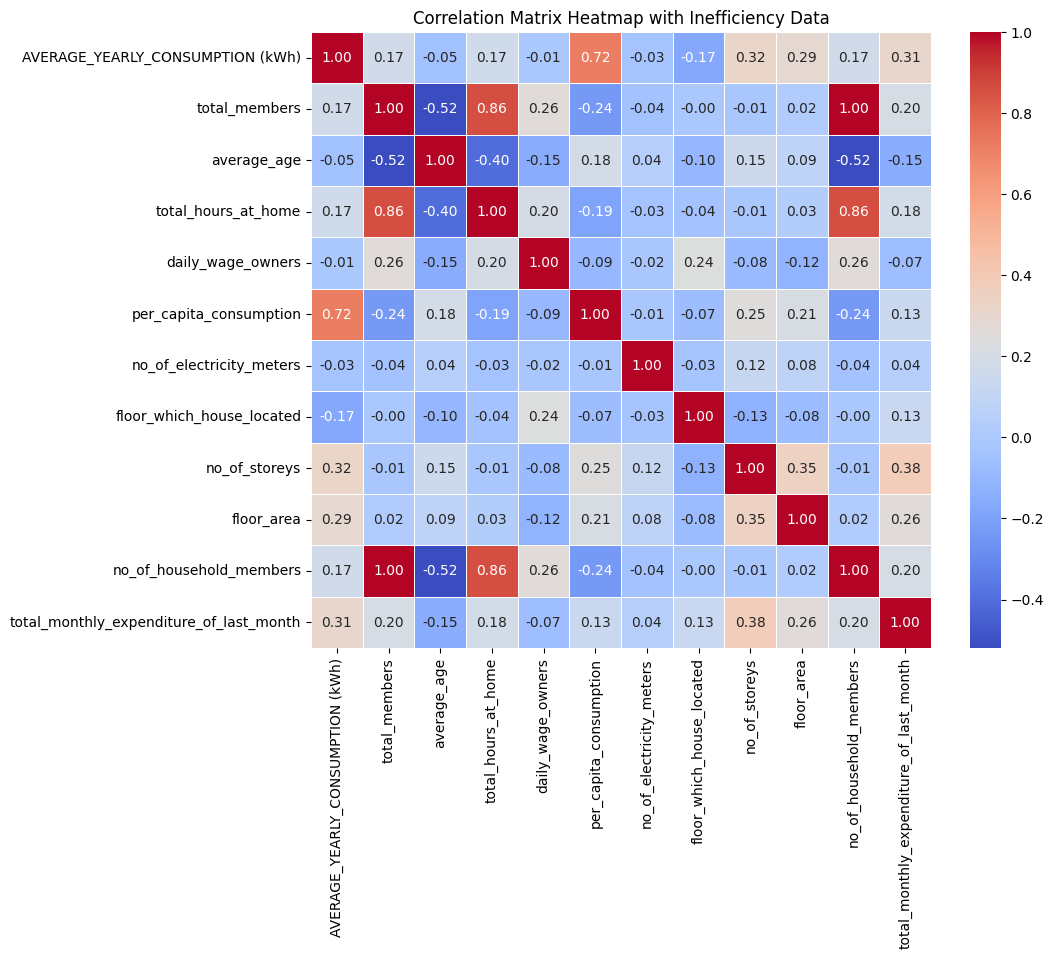

In [73]:
new_household_data = pd.read_csv('w1_household_information_and_history.csv') 

# Merge the new household table with the existing merged_data
final_merged_data = pd.merge(merged_data, new_household_data, on='household_ID', how='left')

# Now 'final_merged_data' has both the demographic, energy, and inefficiency data


# Selecting numeric columns, including the new 'inefficient' column (if it's numeric or can be converted)
correlation_data = final_merged_data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix including the 'inefficient' column
correlation_matrix = correlation_data.corr()

# Visualization: Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap with Inefficiency Data')
plt.show()


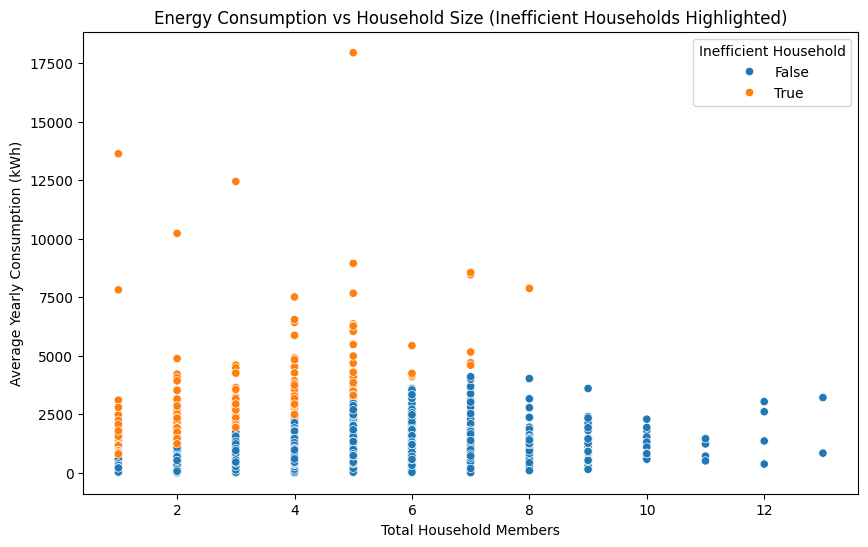

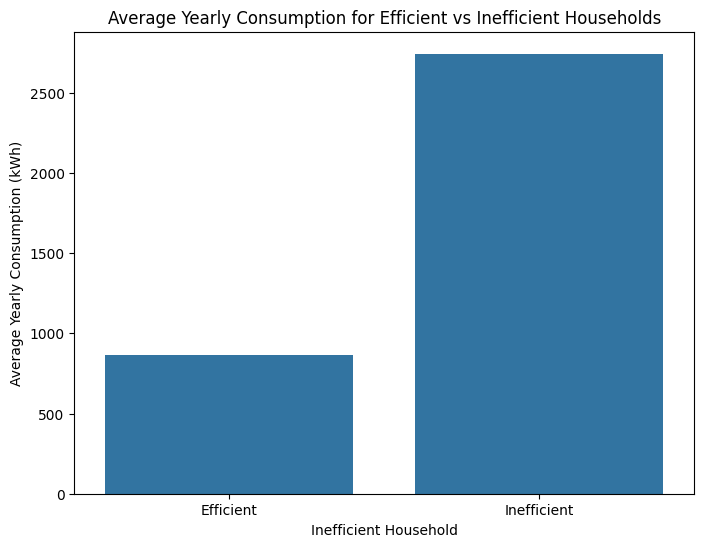

In [74]:
# Scatter plot of energy consumption vs household size, colored by inefficiency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_merged_data, x='total_members', y='AVERAGE_YEARLY_CONSUMPTION (kWh)', hue='inefficient')
plt.title('Energy Consumption vs Household Size (Inefficient Households Highlighted)')
plt.xlabel('Total Household Members')
plt.ylabel('Average Yearly Consumption (kWh)')
plt.legend(title='Inefficient Household')
plt.show()


# Group by inefficiency and calculate mean consumption
inefficiency_analysis = final_merged_data.groupby('inefficient').agg({
    'AVERAGE_YEARLY_CONSUMPTION (kWh)': 'mean',
    'total_members': 'mean'
}).reset_index()

# Visualize the average consumption of inefficient vs efficient households
plt.figure(figsize=(8, 6))
sns.barplot(data=inefficiency_analysis, x='inefficient', y='AVERAGE_YEARLY_CONSUMPTION (kWh)')
plt.title('Average Yearly Consumption for Efficient vs Inefficient Households')
plt.xlabel('Inefficient Household')
plt.ylabel('Average Yearly Consumption (kWh)')
plt.xticks([0, 1], ['Efficient', 'Inefficient'])
plt.show()


In [75]:
from sklearn.cluster import KMeans

# Select relevant numeric features for clustering (e.g., yearly consumption and household size)
X = final_merged_data[['AVERAGE_YEARLY_CONSUMPTION (kWh)', 'total_members']]

# Normalize the data if needed (important for K-Means)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means (choose number of clusters, e.g., 2 clusters for efficient vs inefficient)
kmeans = KMeans(n_clusters=2, random_state=42)
final_merged_data['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Check the resulting clusters (0 or 1) for each household
print(final_merged_data[['household_ID', 'kmeans_cluster']].head())


  household_ID  kmeans_cluster
0       ID0001               0
1       ID0002               0
2       ID0003               1
3       ID0004               1
4       ID0005               0


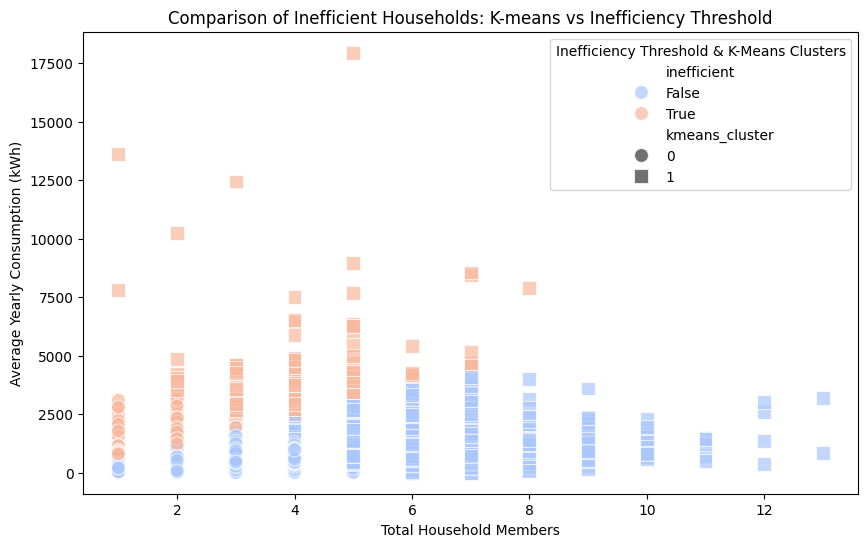

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a comparison plot
plt.figure(figsize=(10, 6))

# Scatter plot of households, color-coded by K-Means cluster and inefficiency
sns.scatterplot(data=final_merged_data, 
                x='total_members', 
                y='AVERAGE_YEARLY_CONSUMPTION (kWh)', 
                hue='inefficient', 
                style='kmeans_cluster', 
                palette='coolwarm', 
                markers=["o", "s"], 
                s=100, 
                alpha=0.7)

# Title and labels
plt.title('Comparison of Inefficient Households: K-means vs Inefficiency Threshold')
plt.xlabel('Total Household Members')
plt.ylabel('Average Yearly Consumption (kWh)')
plt.legend(title='Inefficiency Threshold & K-Means Clusters')

# Show plot
plt.show()


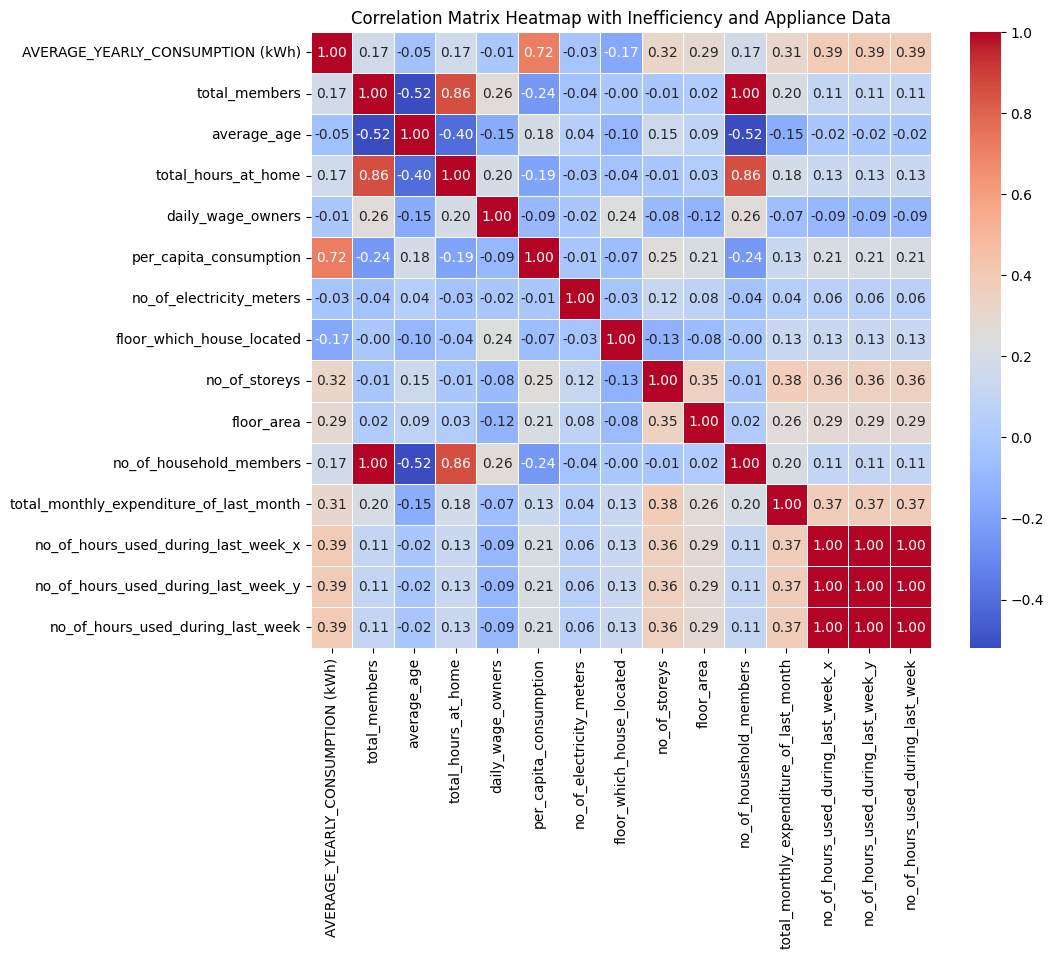

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # To handle missing values

# Load the appliance table
appliance_table = pd.read_csv('w1_appliances.csv')

# Aggregate the appliance usage data by household_ID (sum of hours used for each appliance)
appliance_aggregated = appliance_table.groupby('household_ID')['no_of_hours_used_during_last_week'].sum().reset_index()

# Merge the appliance usage data with the existing final_merged_data
final_merged_data = pd.merge(final_merged_data, appliance_aggregated, on='household_ID', how='left')

# Select relevant numeric columns for correlation analysis (including appliance usage)
correlation_data = final_merged_data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix including appliance usage
correlation_matrix = correlation_data.corr()

# Visualization: Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap with Inefficiency and Appliance Data')
plt.show()


